# Imports

In [7]:
# base
import numpy as np
import networkx as nx
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.cross_validation import run_cv
from feems import setup_graph

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

# Functions

In [8]:
def fit_and_plot_simulation(ax, scenario, sampling_design, rep, n_folds=5,
                            factr=1e7, lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1],
                            true_weights=None, draw_cbar=False, obs_node_size = 1.0, 
                            obs_node_linewidth = .2, cbar_ticklabelsize = 12, 
                            cbar_width = "50%", cbar_height = "10%", cbar_loc = "center", 
                            cbar_bbox_to_anchor = (0.0, -.8, 1, 1), title_loc = "left", 
                            title_pad = "-10", title_fontsize = 0, abs_max = 1):
    print("running", scenario, sampling_design, rep)
    
    # read simulation outputs
    genotypes = np.loadtxt("../output/simulations/{}_{}_rep{}/genotypes.txt".format(scenario, sampling_design, rep))
    edges = np.loadtxt("../output/simulations/{}_{}_rep{}/edges.txt".format(scenario, sampling_design, rep))
    grid = np.loadtxt("../output/simulations/{}_{}_rep{}/grid.txt".format(scenario, sampling_design, rep))
    coord = np.loadtxt("../output/simulations/{}_{}_rep{}/coord.txt".format(scenario, sampling_design, rep))

    # filter to common variants
    n = genotypes.shape[0]
    mu = genotypes.sum(axis=0) / (2.0 * n)
    common_var_idx = (mu >= .05) & (mu <= .95)
    genotypes = genotypes[:, common_var_idx]
    
    # setup spatial graph
    sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)
    
    # if the true weights are not provided run cv
    if true_weights is None:  
        if sampling_design == "missingatrandom":
            n_folds = sp_graph.n_observed_nodes
        
        # run cv
        cv_err = run_cv(
            sp_graph, lamb_grid, n_folds=n_folds, factr=factr, verbose=False
        )
    
        # re-fit solution with min cv err
        mean_cv_err = np.mean(cv_err, axis=0)
        lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])
        sp_graph.fit(float(lamb_cv), verbose=False)
    else:
        # dummy run
        sp_graph.fit(100.0, verbose=False)

    # visualize
    v = Viz(ax, sp_graph, projection=None)
    if true_weights is not None:
        v.norm_log_weights = np.log10(true_weights) - np.mean(np.log10(true_weights))
        v.obs_node_size = 0.0
    else:
        v.obs_node_size = obs_node_size
    v.abs_max = abs_max
    v.obs_node_linewidth = obs_node_linewidth
    v.cbar_ticklabelsize = cbar_ticklabelsize
    v.cbar_width = cbar_width
    v.cbar_height = cbar_height
    v.cbar_loc = cbar_loc
    v.cbar_bbox_to_anchor = cbar_bbox_to_anchor
    if draw_cbar == True:
        v.draw_edge_colorbar()
    v.draw_edges(use_weights=True)
    v.draw_obs_nodes(use_ids=False)
    
    
def get_true_weights(anisotropy_scaler, barrier_w, corridor_w,
                     n_rows=8, n_columns=12, barrier_startpt=2.5, 
                     barrier_endpt=8.5):
    graph, coord, grid, edges = setup_graph(n_rows=n_rows,
                                            n_columns=n_columns,
                                            barrier_startpt=barrier_startpt,
                                            barrier_endpt=barrier_endpt,
                                            anisotropy_scaler=anisotropy_scaler,
                                            barrier_w=barrier_w,
                                            corridor_w=corridor_w)
    W = nx.adjacency_matrix(graph, weight="w")
    idx = nx.adjacency_matrix(graph).nonzero()
    idx = list(np.column_stack(idx))
    true_weights = np.array([])
    for i in range(len(idx)):
        true_weights = np.append(true_weights, W[idx[i][0],idx[i][1]])
    return(true_weights)

# Visualize

running ibdiso nonmissing 0
running hetiso nonmissing 0
running ibdaniso nonmissing 0
running ibdiso nonmissing 0
running hetiso nonmissing 0
running ibdaniso nonmissing 0
running ibdiso missingatrandom 0
running hetiso missingatrandom 0
running ibdaniso missingatrandom 0
CPU times: user 6min 7s, sys: 4.8 s, total: 6min 12s
Wall time: 6min 13s


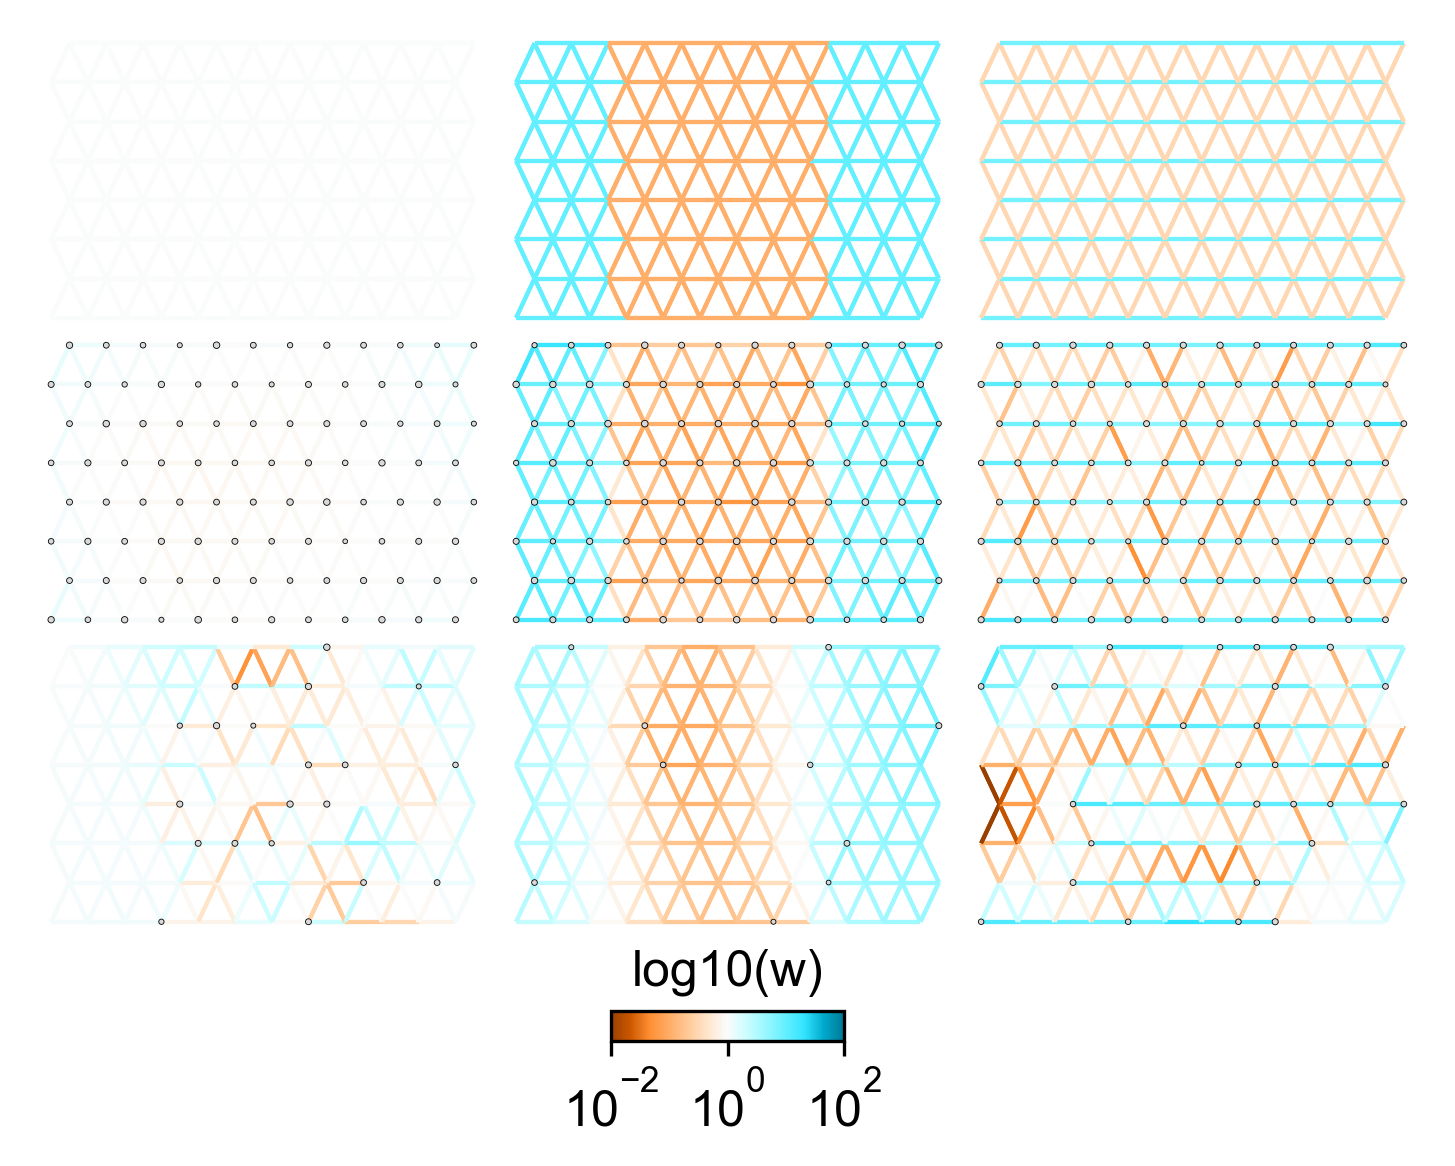

In [9]:
%%time
# get true weights for the simulation settings
true_weights_hom = get_true_weights(anisotropy_scaler=1.0, barrier_w=1.0, corridor_w=1.0)
true_weights_het = get_true_weights(anisotropy_scaler=1.0, barrier_w=.1, corridor_w=1.0)
true_weights_aniso = get_true_weights(anisotropy_scaler=5.0, barrier_w=1.0, corridor_w=1.0)

# setup figure
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(
    ncols=3, nrows=3, figure=fig, wspace=0.0, hspace=0.0
)

# sub-figures
ax_00 = fig.add_subplot(spec[0, 0])
fit_and_plot_simulation(
    ax_00, "ibdiso", "nonmissing", 0, true_weights=true_weights_hom
)

ax_01 = fig.add_subplot(spec[0, 1])
fit_and_plot_simulation(
    ax_01, "hetiso", "nonmissing", 0, true_weights=true_weights_het
)

ax_02 = fig.add_subplot(spec[0, 2])
fit_and_plot_simulation(
    ax_02, "ibdaniso", "nonmissing", 0, true_weights=true_weights_aniso
)

ax_10 = fig.add_subplot(spec[1, 0])
fit_and_plot_simulation(ax_10, "ibdiso", "nonmissing", 0)

ax_11 = fig.add_subplot(spec[1, 1])
fit_and_plot_simulation(ax_11, "hetiso", "nonmissing", 0)

ax_12 = fig.add_subplot(spec[1, 2])
fit_and_plot_simulation(ax_12, "ibdaniso", "nonmissing", 0)

ax_20 = fig.add_subplot(spec[2, 0])
fit_and_plot_simulation(ax_20, "ibdiso", "missingatrandom", 0)

ax_21 = fig.add_subplot(spec[2, 1])
fit_and_plot_simulation(
    ax_21, "hetiso", "missingatrandom", 0, draw_cbar=True
)

ax_22 = fig.add_subplot(spec[2, 2])
fit_and_plot_simulation(ax_22, "ibdaniso", "missingatrandom", 0)

save figure:

In [11]:
fig.savefig("../output/figures/figure2-simulations.pdf", bbox_inches="tight", pad_inches=.5)